<a href="https://www.kaggle.com/code/mahmoudabdrabo17/brain-tumor?scriptVersionId=222904859" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# from google.colab import files
# files.upload()

In [3]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Loading the Data

In [5]:

!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 96%|███████████████████████████████████████▍ | 143M/149M [00:00<00:00, 240MB/s]
100%|█████████████████████████████████████████| 149M/149M [00:00<00:00, 235MB/s]


In [6]:
!unzip /kaggle/working/brain-tumor-mri-dataset.zip

Archive:  /kaggle/working/brain-tumor-mri-dataset.zip
  inflating: Testing/glioma/Te-glTr_0000.jpg  
  inflating: Testing/glioma/Te-glTr_0001.jpg  
  inflating: Testing/glioma/Te-glTr_0002.jpg  
  inflating: Testing/glioma/Te-glTr_0003.jpg  
  inflating: Testing/glioma/Te-glTr_0004.jpg  
  inflating: Testing/glioma/Te-glTr_0005.jpg  
  inflating: Testing/glioma/Te-glTr_0006.jpg  
  inflating: Testing/glioma/Te-glTr_0007.jpg  
  inflating: Testing/glioma/Te-glTr_0008.jpg  
  inflating: Testing/glioma/Te-glTr_0009.jpg  
  inflating: Testing/glioma/Te-gl_0010.jpg  
  inflating: Testing/glioma/Te-gl_0011.jpg  
  inflating: Testing/glioma/Te-gl_0012.jpg  
  inflating: Testing/glioma/Te-gl_0013.jpg  
  inflating: Testing/glioma/Te-gl_0014.jpg  
  inflating: Testing/glioma/Te-gl_0015.jpg  
  inflating: Testing/glioma/Te-gl_0016.jpg  
  inflating: Testing/glioma/Te-gl_0017.jpg  
  inflating: Testing/glioma/Te-gl_0018.jpg  
  inflating: Testing/glioma/Te-gl_0019.jpg  
  inflating: Testing/gliom

In [7]:
# train_dir = '/content/Training'
# test_dir = '/content/Testing'

train_dir = '/kaggle/working/Training'
test_dir = '/kaggle/working/Testing'

## Data Generator

In [8]:
data_gen1=ImageDataGenerator(rescale=1/255,
                             rotation_range=10,
                             width_shift_range=0.02,
                             height_shift_range=0.05,
                             shear_range=0.02,
                             zoom_range=0.05,
                             validation_split=0.2,
                             horizontal_flip=False,
                             vertical_flip=False,
                             fill_mode='nearest'
                             )

print('Data Augmentation 1 was created')

data_gen2=ImageDataGenerator(rescale=1/255,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False,
                             fill_mode='nearest'
                             )
print('Data Augmentation 2 was created')
data_gen3=ImageDataGenerator(rescale=1/255)

Data Augmentation 1 was created
Data Augmentation 2 was created


In [9]:
train_genrator=data_gen1.flow_from_directory(
    directory=train_dir,
    color_mode='rgb',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,

    subset='training'
)
print('Data Augmentation 1 Was Used To Generate Training Data \n')

Found 4571 images belonging to 4 classes.
Data Augmentation 1 Was Used To Generate Training Data 



In [10]:
validation_genrator = data_gen1.flow_from_directory(
   directory=train_dir,
    color_mode='rgb',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

Found 1141 images belonging to 4 classes.


In [11]:
test_genrator=data_gen2.flow_from_directory(
    directory=test_dir,
    color_mode='rgb',
    target_size=(224,224),
    # class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode='categorical'

)
print('Data Augmentation 2 Was Used To Generate Testing Data \n')

Found 1311 images belonging to 4 classes.
Data Augmentation 2 Was Used To Generate Testing Data 



## Extracting Class Names

In [12]:
dict_name = train_genrator.class_indices
class_names = list(dict_name.keys())
print(f'class_names :{class_names}')

class_names :['glioma', 'meningioma', 'notumor', 'pituitary']


## Counting Objects in Each Class in Training Data

In [13]:
Count_train_img = np.unique(train_genrator.classes,return_counts=True)[1]
print(f'Count_Train_Image :{Count_train_img}')

Count_Train_Image :[1057 1072 1276 1166]


In [14]:
print('Number of Image Training :',len(train_genrator.classes))
for i in range(len(class_names)):
  print(f'{class_names[i]} : {Count_train_img[i]}')

Number of Image Training : 4571
glioma : 1057
meningioma : 1072
notumor : 1276
pituitary : 1166


In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=class_names,
    y=Count_train_img,
    text=Count_train_img,
    textposition='auto',
    marker=dict(color=['#636EFA', '#EF553B', '#00CC96', '#AB63FA'])
))
fig.update_layout(
    title="Count data training of Classes",
    xaxis=dict(title="Classes"),
    yaxis=dict(title="Count"),
    width=700,
    height=500
)
fig.show()


In [16]:
import plotly.graph_objects as go
total = sum(Count_train_img)
percentages = [(Count_train_img / total) * 100 for Count_train_img in Count_train_img]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_names,
    y=percentages,
    text=[f'{p:.1f}%' for p in percentages],
    textposition='auto',
    marker=dict(color=['#636EFA', '#EF553B', '#00CC96', '#AB63FA'])
))
fig.update_layout(
    title="Percentage Distribution of Classes",
    xaxis=dict(title="Classes"),
    yaxis=dict(title="Percentage (%)"),
    width=700,
    height=500
)
fig.show()


## Counting Objects in Each Class in Test Data

In [17]:
print('Number of Image testing :',len(test_genrator.classes))
Count_test_img = np.unique(test_genrator.classes,return_counts=True)[1]
for i in range(len(class_names)):
  print(f'{class_names[i]} : {Count_test_img[i]}')

Number of Image testing : 1311
glioma : 300
meningioma : 306
notumor : 405
pituitary : 300


In [18]:
fig = go.Figure()
fig.add_trace(go.Bar(
              x=class_names,
              y=Count_test_img,
              text=Count_test_img,
              textposition='auto',
              marker=dict(color=['#636EFA', '#EF553B', '#00CC96', '#AB63FA'])
))
fig.update_layout(
    title='Distribution Testing Classes',
    xaxis=dict(title='Classes'),
    yaxis=dict(title='Count'),
    width=700,
    height=500
)
fig.show()

## Displaying Random Sample Images

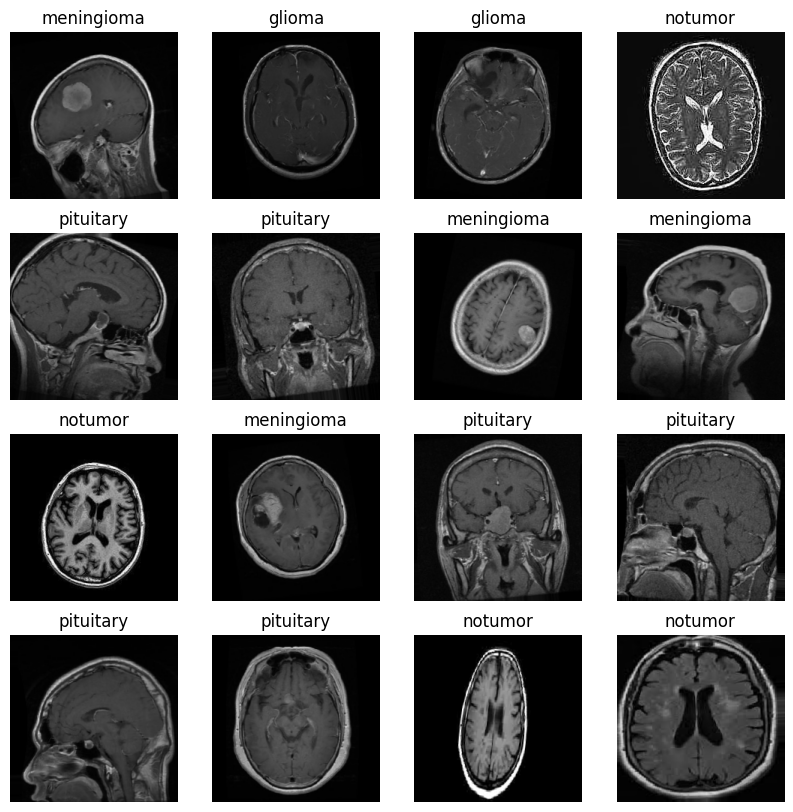

In [19]:
img, label = next(train_genrator)
plt.figure(figsize=(10,10))
for i in range(16):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(img[i])
  plt.title(class_names[np.argmax(label[i])])
  plt.axis('off')

## Building CNN

In [20]:
model = models.Sequential([
    
    layers.Conv2D(filters=16,kernel_size=(3, 3),kernel_regularizer=L2(0.001), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),


    layers.Conv2D(filters=64,kernel_size=(3, 3), kernel_regularizer=L2(0.001),activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(200, activation='relu',kernel_regularizer=L2(0.001)),
    layers.Dense(100, activation='relu',kernel_regularizer=L2(0.001)),
    layers.Dense(200, activation='relu',kernel_regularizer=L2(0.001)),
    layers.Dropout(0.3),
    
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │      37,325,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,376,152 (142.58 MB)

 Trainable params: 37,375,992 (142.58 MB)

 Non-trainable params: 160 (640.00 B)

In [21]:
checkpoint_path = "best_model.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1 )
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
rer=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

#Train the model and Add the checkpoint callback
history = model.fit(
    train_genrator,
    validation_data=validation_genrator,
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint,early_stopping,rer ]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5825 - loss: 6.7369
Epoch 1: val_accuracy improved from -inf to 0.29360, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 464ms/step - accuracy: 0.5834 - loss: 6.7092 - val_accuracy: 0.2936 - val_loss: 4.3757 - learning_rate: 0.0010
Epoch 2/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7461 - loss: 2.9305
Epoch 2: val_accuracy improved from 0.29360 to 0.55916, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 407ms/step - accuracy: 0.7462 - loss: 2.9274 - val_accuracy: 0.5592 - val_loss: 3.0505 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.7940 - loss: 2.0747
Epoch 3: val_accuracy improved from 0.55916 to 0.62577, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 406ms/step - accuracy: 0.7941 - loss: 2.0737 - val_accuracy: 0.6258 - val_loss: 2.2193 - learning_rate: 0.0010
Epoch 4/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/st

In [22]:
loss, accuracy = model.evaluate(validation_genrator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 317ms/step - accuracy: 0.8532 - loss: 0.8936
Loss: 0.8717398643493652, Accuracy: 0.848378598690033


## Accuracy and Val_Accuracy 

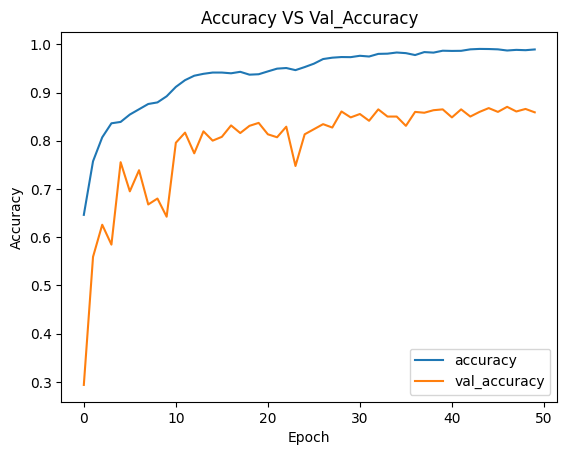

In [23]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy VS Val_Accuracy')
plt.legend()
plt.show()

## Loss and Val_Loss

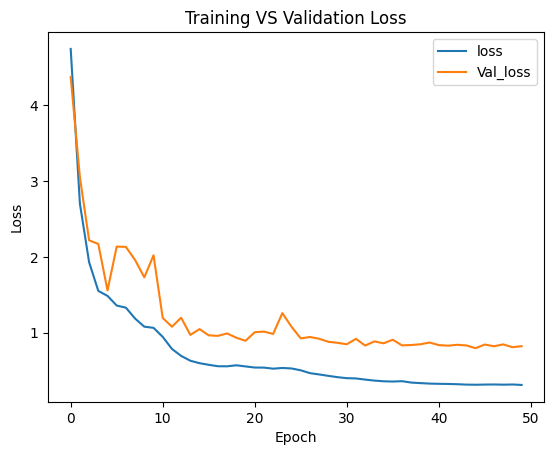

In [24]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training VS Validation Loss')
plt.legend()
plt.show()

## Comparing Model Predictions with True Labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


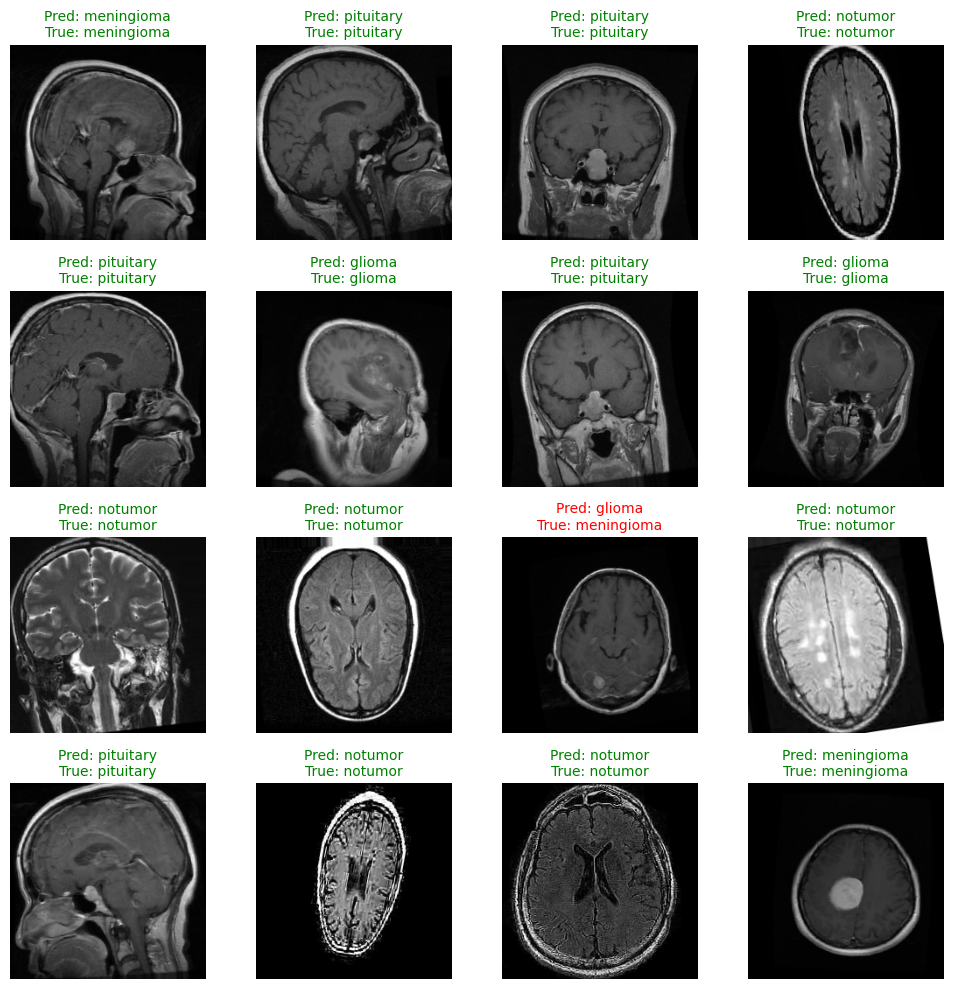

In [25]:

img, label = next(train_genrator)

predictions = model.predict(img)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(label, axis=1)

plt.figure(figsize=(10,10))
for i in range(16):  
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img[i])
    
    
    color = "green" if predicted_labels[i] == true_labels[i] else "red"
    
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[true_labels[i]]}",
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Using MobileNetV2

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import L2



base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False

model_1 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), 
    layers.Dense(256,activation='relu'), 
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax') 
])

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
checkpoint_path = "best_model_mNet.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1 )
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
Reducel=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


history = model_1.fit(
    train_genrator,
    epochs=20, 
    validation_data=validation_genrator,
    batch_size=32,
    callbacks=[checkpoint,early_stopping,Reducel]
     )


Epoch 1/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7293 - loss: 0.6756
Epoch 1: val_accuracy improved from -inf to 0.72393, saving model to best_model_mNet.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 466ms/step - accuracy: 0.7306 - loss: 0.6731 - val_accuracy: 0.7239 - val_loss: 0.7447 - learning_rate: 0.0010
Epoch 2/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8878 - loss: 0.3281
Epoch 2: val_accuracy improved from 0.72393 to 0.79842, saving model to best_model_mNet.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 386ms/step - accuracy: 0.8879 - loss: 0.3278 - val_accuracy: 0.7984 - val_loss: 0.5403 - learning_rate: 0.0010
Epoch 3/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9163 - loss: 0.2445
Epoch 3: val_accuracy did not improve from 0.79842
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 386ms/step - accuracy: 0.9163 - loss: 0.2447 - val_accuracy: 0.7958 - val_loss: 0.5453 - learning_rate: 0.0010
Epoch 4/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.

In [28]:
loss, accuracy = model_1.evaluate(validation_genrator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.8445 - loss: 0.4215
Loss: 0.41950640082359314, Accuracy: 0.8475021719932556


## Comparing Pre_Trining Model Prediction With True Labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


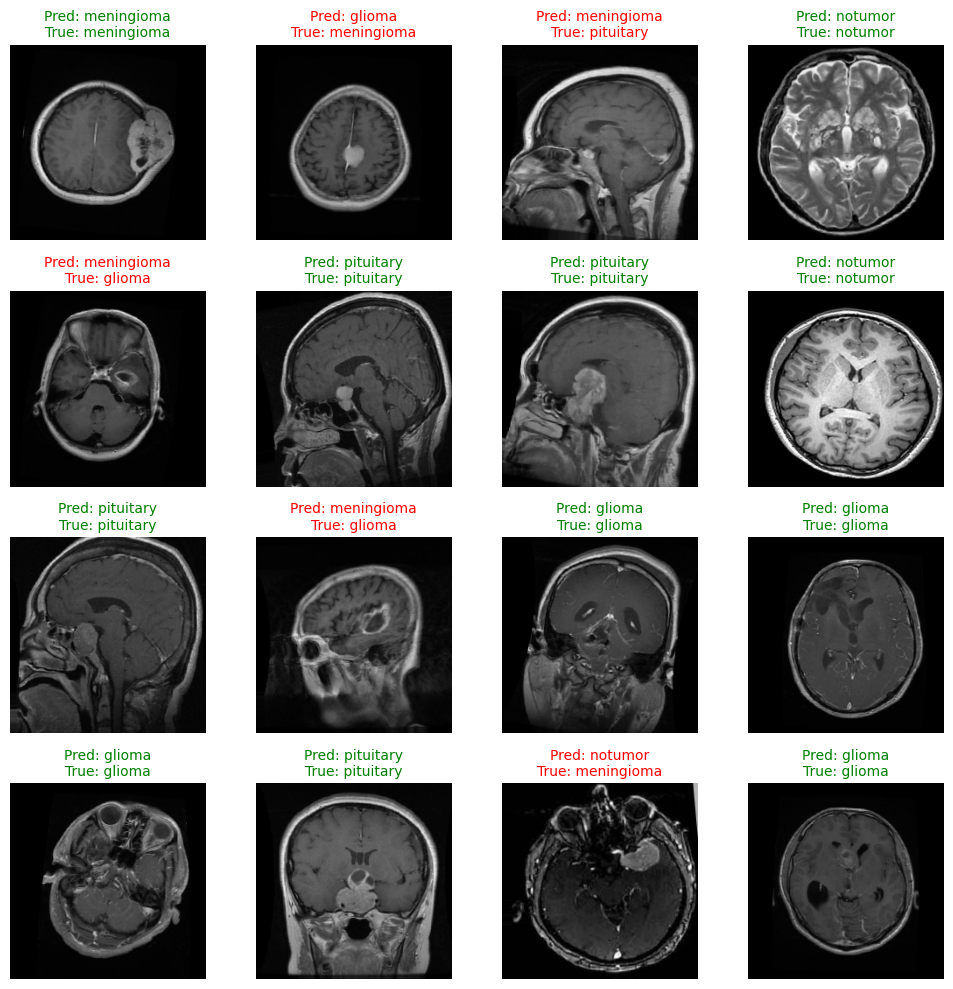

In [29]:

img, label = next(validation_genrator)

predictions = model.predict(img)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(label, axis=1)

plt.figure(figsize=(10,10))
for i in range(16):  
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img[i])
    
    
    color = "green" if predicted_labels[i] == true_labels[i] else "red"
    
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[true_labels[i]]}",
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
